# Exploratory Data Analysis and Feature Engineering
- In this notebook, we explore the raw data of 911 incidents in San Francisco
- Clean the missing data and outliers
- Explore the variables that have impact on the target (Response time)
- Generate extra features in addition to the existing information
- Export the final cleaned and feature engineered dataframe to a csv file for further modeling section

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

import geopandas as gp
from shapely.geometry import point, polygon

import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

%matplotlib inline

In [2]:
def plot_density(data):
    '''
    note: define figsize(x,y) outside of this function
    '''
    xx,ff = sns.kdeplot(data, color='#335CC5', shade=True, gridsize=1000,
                        legend=False).get_lines()[0].get_data() # to get the data
    plt.xlabel('Response time (minutes)')
    plt.ylabel('Density');
    plt.ylim(bottom = 0)
    plt.xlim(left = 0, right = 40);
    
    count = data.shape[0]
    mn = np.round(np.mean(data),2)
    med = np.round(np.median(data),2)
    peak = np.round(xx[ff==max(ff)][0],2)
    
    return count, mn, med, peak

In [3]:
def  points_to_xy(points):
    '''
    Convert centroid point to lat and long
    '''
    s = geopandas.GeoSeries(points)
    long = s.apply(lambda p: p[0])
    lat = s.apply(lambda p: p[1])
    return lat, long

In [4]:
def point_to_LatLong(points):
    '''
    Convert centroid point to lat and long
    '''
    new1 = points.str.split("POINT",expand=True,)
    new2 = new1[1].str.split("(",expand=True,)
    new3 = new2[1].str.split(")",expand=True,)
    new4 = new3[0].str.split(" ",expand=True,)
    
    return new4

In [5]:
# Function to detection outlier on one-dimentional datasets.
def find_anomalies(data):
    anomalies = []
    data_std = data.std()
    data_mean = data.mean()
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit =  data_mean + anomaly_cut_off
    if lower_limit<0:
        lower_limit = 0
        
    print('std: ', data.std(),'mean: ',data.mean(), 'lower_limit: ', lower_limit, 'upper_limit: ', upper_limit)

    return lower_limit, upper_limit

## Import and dataset
- The data source is downloaded from www.DataSF.com
- The dataset contains historical 911 incidents from September 2016 to September 2019
- There are 949,243 incidents in total.

In [6]:
#df = pd.read_csv(io.StringIO(df.to_csv(index=False), index_col=0))
df = pd.read_csv("CallData16_19.csv",index_col=0) # Get rid of 'Unnamed :0'
df.reset_index(drop=True)
df.head(2)

/Users/Jinwen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (20,21,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID
0,192584111,QRV1,19110591,Medical Incident,09/15/2019,09/15/2019,09/15/2019 11:57:18 PM,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:34 PM,...,True,Potentially Life-Threatening,1,SUPPORT,1.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-QRV1
1,192584111,AM120,19110591,Medical Incident,09/15/2019,09/15/2019,09/15/2019 11:57:18 PM,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:37 PM,...,False,Potentially Life-Threatening,1,PRIVATE,2.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-AM120


In [7]:
# Check the shape and missing values
print(df.shape)
df.isnull().sum()

(949243, 34)


Call Number                                  0
Unit ID                                      0
Incident Number                              0
Call Type                                    0
Call Date                                    0
Watch Date                                   0
Received DtTm                                0
Entry DtTm                                   0
Dispatch DtTm                                0
Response DtTm                            24096
On Scene DtTm                           183957
Transport DtTm                          676596
Hospital DtTm                           681116
Call Final Disposition                       0
Available DtTm                             186
Address                                      0
City                                      1897
Zipcode of Incident                        881
Battalion                                    0
Station Area                              2070
Box                                         33
Original Prio

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949243 entries, 0 to 949242
Data columns (total 34 columns):
Call Number                             949243 non-null int64
Unit ID                                 949243 non-null object
Incident Number                         949243 non-null int64
Call Type                               949243 non-null object
Call Date                               949243 non-null object
Watch Date                              949243 non-null object
Received DtTm                           949243 non-null object
Entry DtTm                              949243 non-null object
Dispatch DtTm                           949243 non-null object
Response DtTm                           925147 non-null object
On Scene DtTm                           765286 non-null object
Transport DtTm                          272647 non-null object
Hospital DtTm                           268127 non-null object
Call Final Disposition                  949243 non-null object
Available

### Drop missing values
- Drop the incidents without a specified arrival timestamp and call type.

In [9]:
# Drop the rows where 'On Scene DtTm' has a NaN
df.dropna(subset=['On Scene DtTm'], inplace=True)
print(df.shape)

(765286, 34)


In [10]:
# Drop the rows where 'Call Type Group' has a NaN
df.dropna(subset=['Call Type Group'], inplace=True)
print(df.shape)

(763368, 34)


### Convert date and time into python timestamps
- Cast into the DateTime format, to derive the waiting time.
- Response Time = OnScene TimeDate - Call TimeDate

In [11]:
# convert to datetime
date = pd.to_datetime(df['Call Date'])
df['Call Date'] = date
del date

In [12]:
# convert to datetime
date = pd.to_datetime(df['Received DtTm'])
df['Received DtTm'] = date
del date

In [13]:
# convert to datetime
date = pd.to_datetime(df['On Scene DtTm'])
df['On Scene DtTm'] = date
del date

In [14]:
# convert to datetime
date = pd.to_datetime(df['Transport DtTm'])
df['Transport DtTm'] = date
del date

## Calculate the Response Time
- Drop the data points 3 times standard deviation away from the mean.

In [15]:
#RespTm = (df['On Scene DtTm']-df['Received DtTm']).astype('timedelta64[h]')
df['RespTm'] = df['On Scene DtTm'] - df['Received DtTm']
df['RespTm']=df['RespTm']/np.timedelta64(1,'m') # 's' second, 'm' minute,'h' hour
df.head(2)

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,RespTm
0,192584111,QRV1,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:34 PM,...,Potentially Life-Threatening,1,SUPPORT,1.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-QRV1,3.8
1,192584111,AM120,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:37 PM,...,Potentially Life-Threatening,1,PRIVATE,2.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-AM120,6.1


In [16]:
# Response time of some incidents are less than zero
df['RespTm'].describe() 

count    763368.000000
mean          9.462406
std          10.290680
min        -713.800000
25%           5.416667
50%           7.333333
75%          10.933333
max        1657.433333
Name: RespTm, dtype: float64

In [18]:
# This is an example of such point where response time < 0
temp = df.sort_values(by='RespTm', ascending=True).head()
print('On Scene time = ', temp.loc[396112,'On Scene DtTm'])
print('Received time = ', temp.loc[396112,'Received DtTm'])
print('Timestamp = ', (temp.loc[396112,'On Scene DtTm'] - temp.loc[396112,'Received DtTm'])
        /np.timedelta64(1,'m'))

On Scene time =  2018-06-07 02:07:00
Received time =  2018-06-07 14:00:48
Timestamp =  -713.8


In [19]:
# Find lower and upper limit are the threshold 3*std from the mean
lower_limit, upper_limit = find_anomalies(df['RespTm'])

std:  10.290680395404188 mean:  9.462406488962882 lower_limit:  0 upper_limit:  40.33444767517545


In [20]:
# Remove outliers
df = df[df['RespTm'] > lower_limit]

In [21]:
df = df[df['RespTm'] <= upper_limit]

In [22]:
# Review the cleaned respone time
df['RespTm'].describe()

count    749606.000000
mean          9.133910
std           5.730686
min           0.033333
25%           5.450000
50%           7.333333
75%          10.866667
max          40.333333
Name: RespTm, dtype: float64

count =  749606  mean =  9.13  median =  7.33  peak =  5.79


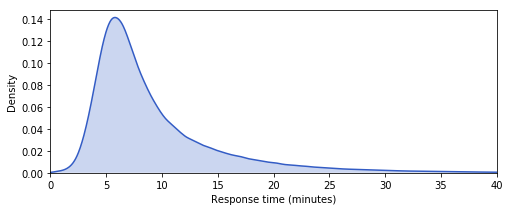

In [23]:
# Draw the desity of the cleaned response time
data = df['RespTm']
figsize(8,3)
count, mn, med, peak = plot_density(data)
print('count = ',count, ' mean = ', mn, ' median = ', med, ' peak = ',peak)

In [50]:
# Reset the index as we drop some points away
df = df.reset_index(drop=True)

# Data Exploration and Feature Engineering

## Convert the GeoLocation to Lat and Long
- The location of the incident in the raw data is a String Type
- The function 'point_to_LatLong' is used to convert the String and creat Lat and Long columns

In [26]:
df[['Longitude','Latitude']] = point_to_LatLong(df['Location'])
df.head(2)

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID,RespTm,Longitude,Latitude
0,192584111,QRV1,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:34 PM,...,SUPPORT,1.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-QRV1,3.8,-122.41259697063744,37.78111921215415
1,192584111,AM120,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:37 PM,...,PRIVATE,2.0,2,6,Tenderloin,POINT (-122.41259697063744 37.78111921215415),192584111-AM120,6.1,-122.41259697063744,37.78111921215415


In [27]:
# Convert Strings to float
df[['Longitude','Latitude']] = df[['Longitude','Latitude']].astype(float)

## Explore the  call times

In [28]:
df['year'] = pd.DatetimeIndex(df['Call Date']).year
print(df['year'].value_counts(sort=False))

2016     81228
2017    245985
2018    247198
2019    175195
Name: year, dtype: int64


In [29]:
df['month'] = pd.DatetimeIndex(df['Call Date']).month
print(df['month'].value_counts(sort=False))

1     63186
2     58051
3     63143
4     60551
5     61800
6     62312
7     60785
8     62284
9     71759
10    62546
11    59966
12    63223
Name: month, dtype: int64


In [30]:
df['day'] = pd.DatetimeIndex(df['Call Date']).day
print(df['day'].value_counts(sort=False))

1     25928
2     25967
3     25819
4     25200
5     25257
6     25109
7     25511
8     26048
9     25478
10    25316
11    24647
12    24691
13    24791
14    24641
15    25008
16    24261
17    24272
18    24380
19    24047
20    23864
21    24716
22    24333
23    24363
24    23472
25    23481
26    23877
27    23497
28    24287
29    21697
30    21529
31    14119
Name: day, dtype: int64


In [31]:
df['dayofweek'] = pd.DatetimeIndex(df['Call Date']).dayofweek
print(df['dayofweek'].value_counts(sort=False))

0    107609
1    105338
2    106418
3    106007
4    110575
5    109416
6    104243
Name: dayofweek, dtype: int64


In [32]:
df['hour'] = pd.DatetimeIndex(df['Received DtTm']).hour
#print(df['hour'].value_counts(sort=False))

## Explore the  dispatch imformation

In [36]:
print( df['Call Type'].value_counts(sort=True) )

Medical Incident                                539068
Alarms                                           83589
Structure Fire                                   48174
Traffic Collision                                29869
Citizen Assist / Service Call                    10919
Other                                             9587
Outside Fire                                      8840
Gas Leak (Natural and LP Gases)                   4499
Electrical Hazard                                 3261
Water Rescue                                      2829
Elevator / Escalator Rescue                       2711
Vehicle Fire                                      1982
Smoke Investigation (Outside)                     1727
Fuel Spill                                         682
Odor (Strange / Unknown)                           629
HazMat                                             303
Explosion                                          167
Industrial Accidents                               139
Train / Ra

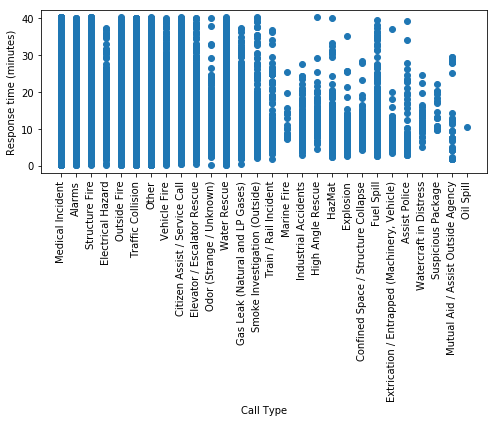

In [37]:
plt.plot(df['Call Type'], df['RespTm'], 'o')
#plt.ylim(0, 500)
plt.xlabel("Call Type")
plt.ylabel("Response time (minutes)")
plt.xticks(rotation=90)
plt.show()

In [38]:
print( df['Call Type Group'].value_counts(sort=True) )

Potentially Life-Threatening    373804
Non Life-threatening            196846
Alarm                           157820
Fire                             21136
Name: Call Type Group, dtype: int64


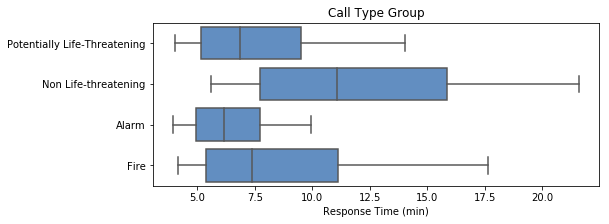

In [39]:
# plot by life-threatening status
figsize(8,3)
sns.boxplot(data = df, y='Call Type Group', x='RespTm', 
            order=["Potentially Life-Threatening", "Non Life-threatening", 'Alarm', 'Fire'],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('Call Type Group');
#plt.xlim((3,25));
plt.yticks((0,1,2,3),("Potentially Life-Threatening", "Non Life-threatening", 'Alarm', 'Fire'));

In [40]:
print( df['Final Priority'].value_counts(sort=False) )

2    231732
3    517874
Name: Final Priority, dtype: int64


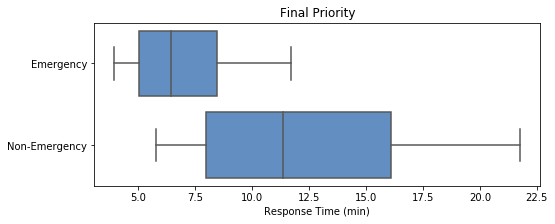

In [41]:
figsize(8,3)
sns.boxplot(data = df, y='Final Priority', x='RespTm', 
            order=[3,2],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('Final Priority');
#plt.xlim((3,25));
plt.yticks((0,1),("Emergency", "Non-Emergency"));

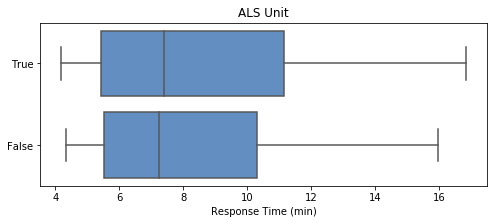

In [42]:
figsize(8,3)
sns.boxplot(data = df, y='ALS Unit', x='RespTm', 
            order=[True,False],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('ALS Unit');
#plt.xlim((3,25));
plt.yticks((0,1),("True", "False"));

In [43]:
print( df['Unit Type'].value_counts(sort=True) )

ENGINE            273622
MEDIC             252342
PRIVATE            87015
TRUCK              58243
CHIEF              44811
RESCUE CAPTAIN     15980
SUPPORT            11916
RESCUE SQUAD        5268
INVESTIGATION        409
Name: Unit Type, dtype: int64


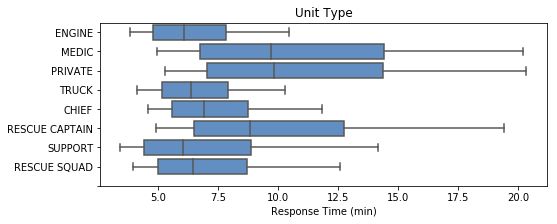

In [44]:
figsize(8,3)
sns.boxplot(data = df, y='Unit Type', x='RespTm', 
            order=["ENGINE", "MEDIC", 'PRIVATE', 'TRUCK',
                   'CHIEF','RESCUE CAPTAIN','SUPPORT','RESCUE SQUAD'],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('Unit Type');
#plt.xlim((3,25));
plt.yticks((0,1,2,3,4,5,6,7,8),("ENGINE", "MEDIC", 'PRIVATE', 'TRUCK',
                       'CHIEF','RESCUE CAPTAIN','SUPPORT','RESCUE SQUAD')); 

In [45]:
print( df['Number of Alarms'].value_counts(sort=True) )

1    748514
2       851
3       176
4        65
Name: Number of Alarms, dtype: int64


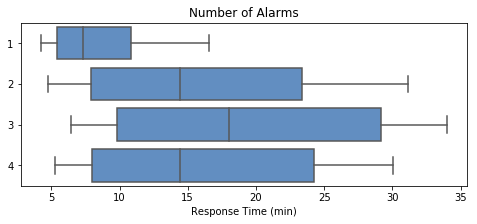

In [46]:
figsize(8,3)
sns.boxplot(data = df, y='Number of Alarms', x='RespTm', 
            order=[1,2,3,4],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('Number of Alarms');
#plt.xlim((3,25));
plt.yticks((0,1,2,3),('1','2','3','4'));

In [47]:
print( df['Call Final Disposition'].value_counts(sort=True) )

Code 2 Transport              406025
Fire                          172742
Patient Declined Transport     40549
Code 3 Transport               38542
No Merit                       33308
Against Medical Advice         15218
Unable to Locate               11577
Medical Examiner                9440
Cancelled                       8362
Other                           6044
SFPD                            4376
Gone on Arrival                 3022
CHP                              225
Duplicate                         97
Multi-casualty Incident           79
Name: Call Final Disposition, dtype: int64


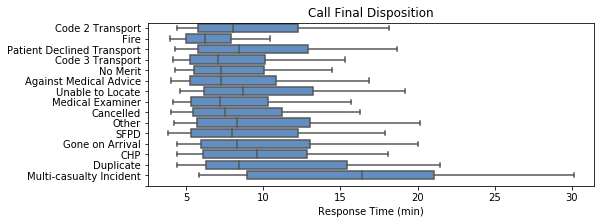

In [48]:
figsize(8,3)
sns.boxplot(data = df, y='Call Final Disposition', x='RespTm', 
            order=['Code 2 Transport','Fire','Patient Declined Transport','Code 3 Transport',
                  'No Merit','Against Medical Advice','Unable to Locate','Medical Examiner',
                  'Cancelled', 'Other','SFPD','Gone on Arrival','CHP','Duplicate','Multi-casualty Incident'],
            orient = 'h', color = '#528DD1',
            width=0.8, linewidth=1.5, showfliers=False, whis=[10, 90])
plt.ylabel('')
plt.xlabel('Response Time (min)');
plt.title('Call Final Disposition');
#plt.xlim((3,25));
plt.yticks((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15),('Code 2 Transport','Fire','Patient Declined Transport','Code 3 Transport',
                  'No Merit','Against Medical Advice','Unable to Locate','Medical Examiner',
                  'Cancelled', 'Other','SFPD','Gone on Arrival','CHP','Duplicate','Multi-casualty Incident'));

In [49]:
df.shape

(749606, 42)

## Fire station and hospital location
- Import the fire station and hospital location in SF.
- Calculate the distance from the incident to the nearest fire station and hospital

In [51]:
def calc_min_distance(df_main,df_fire,df_hosp):
    '''
    calculate the distance between the incident and the nearest hospital and fire station
    '''
    data_lat = df_main['Latitude'].values
    data_long = df_main['Longitude'].values
    
    fire_lat = df_fire['latitude_fire'].values
    fire_long = df_fire['longitude_fire'].values
    
    hosp_lat = df_hosp['Lat_hospital'].values
    hosp_long = df_hosp['Long_hospital'].values
    
    nitem = df_main.shape[0]
    n_fire = df_fire.shape[0]
    n_hosp = df_hosp.shape[0]
    
    dist_fire_min = np.zeros((nitem,1))
    dist_fire_med = np.zeros((nitem,1))
    
    dist_hosp_min = np.zeros((nitem,1))
    dist_hosp_med = np.zeros((nitem,1))
    
    for i in np.arange(nitem):
        tempj = []
        tempk = []
        
        for j in np.arange(n_hosp):
            dist = abs(hosp_lat[j] - data_lat[i]) + abs(hosp_long[j] -data_long[i])
            tempj.append(dist)
            
        for k in np.arange(n_fire):
            dist = abs(fire_lat[k] - data_lat[i]) + abs(fire_long[k] -data_long[i])
            tempk.append(dist) 
        
        dist_hosp_min[i] = min(tempj)
        #dist_hosp_med[i] = np.median(tempj)
        
        dist_fire_min[i] = min(tempk)
        #dist_fire_med[i] = np.median(tempk)
        
    df_main['dist_fire_min'] = dist_fire_min
    #df_main['dist_fire_med'] = dist_fire_med
    df_main['dist_hosp_min'] = dist_hosp_min
    #df_main['dist_hosp_med'] = dist_hosp_med
    
    return df_main

In [52]:
# Import the location (latitude and longitude) of fire station and hospital
df_hosp = pd.read_csv("Hospital_location.csv")
df_fire = pd.read_csv("fire_station_location.csv")

In [53]:
# Calcuate the distance and creat two extra columns 'dist_fire_min' and 'dist_hosp_min'
df = calc_min_distance(df,df_fire,df_hosp)

In [54]:
df.head(2)

,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,...,RespTm,Longitude,Latitude,year,month,day,dayofweek,hour,dist_fire_min,dist_hosp_min
0,192584111,QRV1,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:34 PM,...,3.8,-122.412597,37.781119,2019,9,15,6,23,0.010216,0.012384
1,192584111,AM120,19110591,Medical Incident,2019-09-15,09/15/2019,2019-09-15 23:57:18,09/15/2019 11:58:36 PM,09/15/2019 11:58:47 PM,09/15/2019 11:59:37 PM,...,6.1,-122.412597,37.781119,2019,9,15,6,23,0.010216,0.012384


In [ ]:
# Export the final dataframe for modeling
export_df = df.to_csv(r'model_fire_hosp.csv')